In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from module.periocular_cnn import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
iris_data, iris_label = create_dataset('Iris-Dataset/CASIA-Iris-Thousand')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
iris_data, iris_label, img_label = combine_LR(iris_data, iris_label, 1000, 10)

In [4]:
X_train, X_test, y_train, y_test, label_train, label_test = train_test_split(iris_data, iris_label, img_label, test_size=0.2, stratify=iris_label)

In [28]:
def make_pairs(images, labels, img_label, set=1):
    pairImages = []
    pairLabels = []
    imageLabels = []

    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label = labels[idxA]
        for _ in range(set):
            posIdx = idx[label]
            while True:
                # randomly pick an image that belongs to the *same* class
                idxB = np.random.choice(posIdx)
                posIdx = np.delete(posIdx, np.where(posIdx == idxB))
                if idxB != idxA:
                    break
            posImage = images[idxB]
            # prepare a positive pair and update the images and labels
            # lists, respectively
            pairImages.append([currentImage, posImage])
            pairLabels.append([1])
            imageLabels.append([str(labels[idxA]).zfill(
                3) + img_label[idxA], str(labels[idxB]).zfill(3) + img_label[idxB]])

            # grab the indices for each of the class labels *not* equal to
            # the current label and randomly pick an image corresponding
            # to a label *not* equal to the current label
            negIdx = np.where(labels != label)[0]
            while True:
                idxC = np.random.choice(negIdx)
                negIdx = np.delete(negIdx, np.where(negIdx == idxC))
                if idxC != idxA:
                    break
            negImage = images[idxC]
            # prepare a negative pair of images and update our lists
            pairImages.append([currentImage, negImage])
            pairLabels.append([0])
            imageLabels.append([str(labels[idxA]).zfill(
                3) + img_label[idxA], str(labels[idxC]).zfill(3) + img_label[idxC]])

    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels), np.array(imageLabels))

In [30]:
X_train_pair, y_train_pair, label_train_pair = make_pairs(X_train, y_train.astype(int), label_train, 4)

In [31]:
label_train_pair[0:40]

array([['70003', '70005'],
       ['70003', '01002'],
       ['70003', '70009'],
       ['70003', '27005'],
       ['70003', '70004'],
       ['70003', '99403'],
       ['70003', '70001'],
       ['70003', '95403'],
       ['53109', '53103'],
       ['53109', '80603'],
       ['53109', '53107'],
       ['53109', '31100'],
       ['53109', '53107'],
       ['53109', '72104'],
       ['53109', '53107'],
       ['53109', '03106'],
       ['71600', '71608'],
       ['71600', '19304'],
       ['71600', '71608'],
       ['71600', '45900'],
       ['71600', '71603'],
       ['71600', '73604'],
       ['71600', '71608'],
       ['71600', '09500'],
       ['26407', '26401'],
       ['26407', '72201'],
       ['26407', '26405'],
       ['26407', '67902'],
       ['26407', '26409'],
       ['26407', '24005'],
       ['26407', '26406'],
       ['26407', '00401'],
       ['41708', '41709'],
       ['41708', '36609'],
       ['41708', '41701'],
       ['41708', '27602'],
       ['41708', '41701'],
 

In [ ]:
X_test_pair, y_test_pair, label_test_pair = make_pairs(X_test, y_test.astype(int), label_test, 1)

# VGG16 Model

In [2]:
from tensorflow.keras.applications import ResNet101, ResNet50, VGG16, VGG19, InceptionV3, InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

In [4]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

In [5]:
# reset the default graph
tf.compat.v1.reset_default_graph()

# create a new session
sess = tf.compat.v1.Session()

In [9]:
# with tf.device('/cpu:0'):
#     X_train_a = tf.convert_to_tensor(vgg16_preprocess_input(X_train_pair[:, 0]), np.float32)
#     X_train_b = tf.convert_to_tensor(vgg16_preprocess_input(X_train_pair[:, 1]), np.float32)
#     y_train_final = tf.convert_to_tensor(y_train_pair.reshape(-1,1), np.float32)

#     X_test_a = tf.convert_to_tensor(vgg16_preprocess_input(X_test_pair[:, 0]), np.float32)
#     X_test_b = tf.convert_to_tensor(vgg16_preprocess_input(X_test_pair[:, 1]), np.float32)
#     y_test_final = tf.convert_to_tensor(y_test_pair.reshape(-1,1), np.float32)

In [17]:
X_train_a = vgg16_preprocess_input(X_train_pair[:, 0])
X_train_b = vgg16_preprocess_input(X_train_pair[:, 1])
y_train_final = y_train_pair.reshape(-1)

X_test_a = vgg16_preprocess_input(X_test_pair[:, 0])
X_test_b = vgg16_preprocess_input(X_test_pair[:, 1])
y_test_final = y_test_pair.reshape(-1)

In [18]:
with tf.device('/cpu:0'):
    features_train_a = model_vgg.predict(X_train_a)
    features_train_b = model_vgg.predict(X_train_b)
    features_test_a = model_vgg.predict(X_test_a)
    features_test_b = model_vgg.predict(X_test_b)

125/125 [==============================] - 50s 400ms/step


In [19]:
# # save the features to a file
# np.savez('temp_data/features.npz', 
#          features_train_a=features_train_a, 
#          features_train_b=features_train_b,
#          label_train=y_train_final, 
#          img_label_train=label_train_pair,
         
#          features_test_a=features_test_a, 
#          features_test_b=features_test_b,
#          label_test=y_test_final,
#          img_label_test=label_test_pair)

In [3]:
# load the features from the file
with np.load('temp_data/features.npz') as data:
    features_train_a = data['features_train_a']
    features_train_b = data['features_train_b']
    y_train_final = data['label_train']
    img_label_train = data['img_label_train']
    
    features_test_a = data['features_test_a']
    features_test_b = data['features_test_b']
    y_test_final = data['label_test']
    img_label_test = data['img_label_test']

## Create all scores for score fusion with SVM

In [4]:
from module.Iris_recognition import *
from module.Periocular_recognition import *
from module.score_fusion import *
from module.iris_scores import *

In [5]:
# iris_norm_L = np.load('temp_data/iris_norm_L_all.npy')
# iris_norm_R = np.load('temp_data/iris_norm_R_all.npy')

In [6]:
# load the features from the file
with np.load('temp_data/iris_norm_seg_all.npz') as data:
    iris_norm_L = data['iris_norm_L']
    iris_norm_R = data['iris_norm_R']

In [7]:
int(img_label_train[1][1][:-2]), int(img_label_train[1][1][-2:])

(494, 2)

In [8]:
fusion_scores_test = get_fusion_scores_multi_process(iris_norm_L, iris_norm_R, img_label_test)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [9]:
list(fusion_scores_test)

[array([[0.48042439, 0.4695479 ],
        [0.6637621 , 0.64544693],
        [0.24162694, 0.23444535],
        [0.6106777 , 0.56270615]]),
 array([[0.47102681, 0.4792403 ],
        [0.67007214, 0.65663108],
        [0.234933  , 0.23932232],
        [0.49411765, 0.61073425]]),
 array([[0.47221925, 0.4864391 ],
        [0.65483775, 0.65654579],
        [0.23570958, 0.24289384],
        [0.51260077, 0.62048526]]),
 array([[0.47750997, 0.48117461],
        [0.64857168, 0.64967694],
        [0.23863372, 0.24034806],
        [0.61069655, 0.64306159]]),
 array([[0.36684976, 0.33543101],
        [0.5406613 , 0.50859663],
        [0.18301652, 0.16722259],
        [0.33455314, 0.3616    ]]),
 array([[0.47916308, 0.47110735],
        [0.65417531, 0.6486172 ],
        [0.2424945 , 0.24121714],
        [0.60560753, 0.6377363 ]]),
 array([[0.47404397, 0.47169168],
        [0.6444365 , 0.64716893],
        [0.23711786, 0.24405764],
        [0.55813233, 0.62938523]]),
 array([[0.47492788, 0.47947068],


In [10]:
fusion_scores_train = get_fusion_scores_multi_process(iris_norm_L, iris_norm_R, img_label_train)

  0%|          | 0/16000 [00:00<?, ?it/s]

In [45]:
# # save the features to a file
# np.savez('temp_data/fusion_scores_seg.npz',
#          fusion_scores_train=fusion_scores_train, 
#          fusion_scores_test=fusion_scores_test)

In [21]:
# load the features from the file
with np.load('temp_data/fusion_scores_enhanced.npz') as data:
    fusion_scores_train = data['fusion_scores_train']
    fusion_scores_test = data['fusion_scores_test']

## Classification by machine learning

In [11]:
import logging

logger = logging.getLogger("sklearnex")
logger.setLevel(logging.WARNING)  # Set the logger's logging level to WARNING or higher

In [12]:
X_train_scaled, X_test_scaled = feature_preprocessing(features_train_a, features_test_a, features_train_b, features_test_b, fusion_scores_train, fusion_scores_test, use_fusion=True)

### SVM

In [1]:
import sklearn.svm as svm

#### Search for best hyper parameter

In [29]:
param = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid_search = get_best_param(X_train_scaled, y_train_final, svm.SVC(), param)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  26.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  26.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  27.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  25.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  28.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   5.6s
[CV] END .....................C=0.1, gamma=1, k

: 

In [ ]:
# print the best parameters and score
print("Best Score: ", grid_search.best_score_)
print("Best Estimator: ", grid_search.best_estimator_)

Best Parameters:  {'C': 10, 'gamma': 0.01, 'kernel': 'poly'}
Best Score:  0.8922500000000001
Best Estimator:  SVC(C=10, gamma=0.01, kernel='poly')


#### SVM Training

In [15]:
# create an SVM classifier with a Gaussian kernel
clf = svm.SVC(kernel='rbf', C=10, gamma=0.0001, verbose=2)

# train the classifier
clf.fit(X_train_scaled, y_train_final)

SVC(C=10, gamma=0.0001, verbose=2)

#### Save Model

In [89]:
# pickle.dump(clf, open('Model/svm_VGG16_fusion_enha.pickle', 'wb'))

In [17]:
clf = pickle.load(open('Model/svm_VGG16_fusion_enha.pickle', "rb"))

#### Cross validation

In [24]:
from sklearn.model_selection import cross_validate

In [21]:
# create an SVM classifier with a Gaussian kernel
clf = svm.SVC(kernel='rbf', C=10, gamma=0.0001, verbose=2)

X = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y = np.concatenate((y_train_final, y_test_final), axis=0)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)

In [22]:
print('Accuracy:', scores['test_accuracy'])
print('Precision:', scores['test_precision_macro'])
print('Recall:', scores['test_recall_macro'])

Accuracy: [0.93325 0.92    0.9325  0.92225 0.90525]
Precision: [0.93338272 0.92024206 0.93259733 0.92259325 0.90694298]
Recall: [0.93325 0.92    0.9325  0.92225 0.90525]


#### Performance evaluation

In [16]:
y_predict = clf.predict(X_test_scaled)

In [17]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2000
           1       0.96      0.88      0.92      2000

    accuracy                           0.92      4000
   macro avg       0.92      0.92      0.92      4000
weighted avg       0.92      0.92      0.92      4000



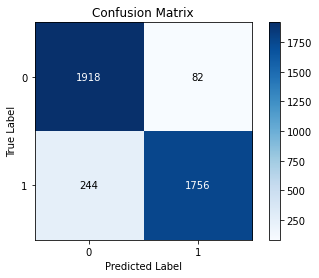

In [18]:
plot_confusion_matrix(y_test_final, y_predict)

### K-Nearest Neighbor

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train_final)

KNeighborsClassifier()

In [26]:
y_predict = knn.predict(X_test_scaled)

In [27]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.79      0.48      0.60      2000
           1       0.63      0.88      0.73      2000

    accuracy                           0.68      4000
   macro avg       0.71      0.68      0.66      4000
weighted avg       0.71      0.68      0.66      4000



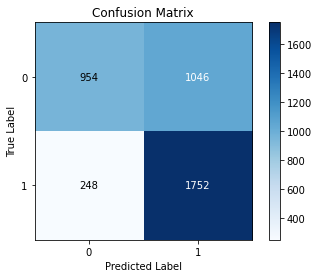

In [28]:
plot_confusion_matrix(y_test_final, y_predict)

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

#### Search for best parameter

In [77]:
param = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = get_best_param(X_train_scaled, y_train_final, RandomForestClassifier(), param)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_dep

In [78]:
# print the best parameters and score
print("Best Score: ", grid_search.best_score_)
print("Best Estimator: ", grid_search.best_estimator_)

Best Score:  0.9399375000000001
Best Estimator:  RandomForestClassifier(min_samples_split=5, n_estimators=200)


#### Train and test

In [20]:
# Create a Random Forest classifier with 100 trees
rfc = RandomForestClassifier(min_samples_split=5, n_estimators=200)

# Train the classifier on your data
rfc.fit(X_train_scaled, y_train_final)

RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [93]:
# pickle.dump(rfc, open('Model/rfc_VGG16_fusion_enha.pickle', 'wb'))

In [30]:
rfc = pickle.load(open('Model/rfc_VGG16_fusion.pickle', "rb"))

In [21]:
# Predict the labels of the test data
y_predict = rfc.predict(X_test_scaled)

In [22]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2000
           1       0.97      0.88      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



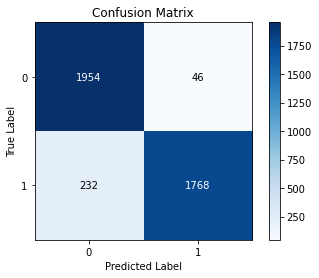

In [23]:
plot_confusion_matrix(y_test_final, y_predict)

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [98]:
param = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}
grid_search = get_best_param(X_train_scaled, y_train_final, LogisticRegression(), param)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   4.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   4.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   4.3s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   4.4s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   3.6s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=  57.2s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=  56.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=  56.9s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=  57.4s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=  56.6s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  21.7s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  17.8s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  21.5s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  17.8s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  20.5s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  40.0s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  40.0s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  40.1s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  40.5s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=  41.8s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=  18.9s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=  19.5s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=  11.4s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=  18.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=  11.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l1, solver=saga; total time=  50.7s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l1, solver=saga; total time=  50.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l1, solver=saga; total time=  50.4s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l1, solver=saga; total time=  50.1s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l1, solver=saga; total time=  50.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  32.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  33.4s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  27.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  28.2s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  28.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l2, solver=saga; total time=  40.1s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l2, solver=saga; total time=  37.4s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l2, solver=saga; total time=  40.2s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l2, solver=saga; total time=  40.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .......................C=1, penalty=l2, solver=saga; total time=  37.8s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.9min
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.0min
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 3.7min
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.1min
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.8min


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  52.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  52.2s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  52.2s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  52.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  51.6s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  27.7s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  29.5s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  27.4s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  29.4s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  32.1s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l2, solver=saga; total time=  38.3s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l2, solver=saga; total time=  38.2s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l2, solver=saga; total time=  39.9s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l2, solver=saga; total time=  38.0s


c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=10, penalty=l2, solver=saga; total time=  38.4s


In [99]:
# print the best parameters and score
print("Best Score: ", grid_search.best_score_)
print("Best Estimator: ", grid_search.best_estimator_)

Best Score:  0.9376874999999998
Best Estimator:  LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


In [25]:
# Create a Logistic Regression classifier
lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# Train the classifier on your data
lr.fit(X_train_scaled, y_train_final)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [97]:
# pickle.dump(lr, open('Model/lr_VGG16_fusion_enha.pickle', 'wb'))

In [35]:
lr = pickle.load(open('Model/lr_VGG16_fusion.pickle', "rb"))

In [26]:
# Predict the labels of the test data
y_predict = lr.predict(X_test_scaled)

In [27]:
print(classification_report(y_test_final,y_predict))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2000
           1       0.94      0.93      0.93      2000

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



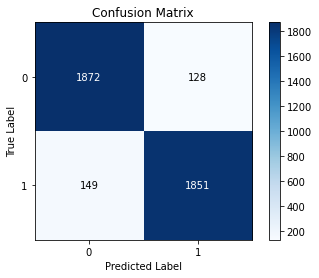

In [28]:
plot_confusion_matrix(y_test_final, y_predict)

## Classification by CNN

### Pretrained CNN

In [39]:
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64,128,3))

input_dim = X_train_pair.shape[2:]

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = model_vgg(img_a)
feat_vecs_b = model_vgg(img_b)

flatten_a = Flatten()(feat_vecs_a)
flatten_b = Flatten()(feat_vecs_b)

distance = Lambda(euclidean_distance)([flatten_a, flatten_b])
outputs = Dense(1, activation="sigmoid")(distance)
model_vgg = Model(inputs=[img_a, img_b], outputs=outputs)

model_vgg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_6 (InputLayer)           [(None, 64, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 vgg16 (Functional)             (None, 2, 4, 512)    14714688    ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [24]:
# compile the model
print("[INFO] compiling model...")
model_vgg.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

[INFO] compiling model...


In [47]:
set_gpu()

In [38]:
# train the model
print("[INFO] training model...")
history = model_vgg.fit(
	[X_train_a, X_train_b], y_train_final,
	batch_size=32, # reducing batch size
	epochs=100
)

[INFO] training model...
Epoch 1/100
500/500 [==============================] - 73s 146ms/step - loss: 0.6932 - accuracy: 0.4972
Epoch 2/100
500/500 [==============================] - 74s 148ms/step - loss: 0.6932 - accuracy: 0.4972
Epoch 3/100
500/500 [==============================] - 74s 149ms/step - loss: 0.6932 - accuracy: 0.4909
Epoch 4/100
500/500 [==============================] - 74s 148ms/step - loss: 0.6932 - accuracy: 0.4951
Epoch 5/100
500/500 [==============================] - 74s 148ms/step - loss: 0.6932 - accuracy: 0.4936
Epoch 6/100
500/500 [==============================] - 75s 150ms/step - loss: 0.6932 - accuracy: 0.4959
Epoch 7/100
500/500 [==============================] - 75s 150ms/step - loss: 0.6932 - accuracy: 0.4921
Epoch 8/100
500/500 [==============================] - 75s 149ms/step - loss: 0.6932 - accuracy: 0.4970
Epoch 9/100
500/500 [==============================] - 75s 149ms/step - loss: 0.6932 - accuracy: 0.4984
Epoch 10/100
500/500 [=================

KeyboardInterrupt: 

### Normal CNN

In [58]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)
	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
	x = Dropout(0.3)(x)
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
	x = Dropout(0.3)(x)
 	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim)(pooledOutput)
	# build the model
	model = Model(inputs, outputs)
	# return the model to the calling function
	return model

In [59]:
imgA = Input(shape=X_train_pair.shape[2:])
imgB = Input(shape=X_train_pair.shape[2:])
featureExtractor = build_siamese_model(X_train_pair.shape[2:])
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

In [60]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [61]:
with tf.device('/cpu:0'):
    X_train_a = tf.convert_to_tensor(X_train_pair[:, 0], np.float32)
    X_train_b = tf.convert_to_tensor(X_train_pair[:, 1], np.float32)
    y_train_final = tf.convert_to_tensor(y_train_pair.reshape(-1,1), np.float32)
    
    X_test_a = tf.convert_to_tensor(X_test_pair[:, 0], np.float32)
    X_test_b = tf.convert_to_tensor(X_test_pair[:, 1], np.float32)
    y_test_final = tf.convert_to_tensor(y_test_pair.reshape(-1,1), np.float32)

In [63]:
set_gpu()

In [64]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[X_train_a, X_train_b], y_train_final,
	validation_data=([X_test_a, X_test_b], y_test_final),
	batch_size=32, 
	epochs=100)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
500/500 [==============================] - 14s 26ms/step - loss: 0.7163 - accuracy: 0.4863 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6934 - accuracy: 0.4931 - val_loss: 0.6950 - val_accuracy: 0.4970
Epoch 3/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6934 - accuracy: 0.4963 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 4/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6933 - accuracy: 0.4945 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 5/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6933 - accuracy: 0.4934 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 6/100
500/500 [==============================] - 13s 25ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.4988
Epoch 7/100
500/500 [==============================] - 13s 25ms/step - loss: 0.

KeyboardInterrupt: 

In [50]:
def test_model(model, X_test_a, X_test_b, y_test_final):
    # evaluate the model on the test data
    print("[INFO] evaluating model...")
    loss, accuracy = model.evaluate([X_test_a, X_test_b], y_test_final, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy*100:.2f}%")

    # make predictions on the test data
    print("[INFO] making predictions...")
    y_pred = model.predict([X_test_a, X_test_b])
    y_pred = (y_pred > 0.5).astype(int)

    # print the classification report
    print("[INFO] classification report...")
    print(classification_report(y_test_final, y_pred))

In [52]:
set_gpu()

In [53]:
test_model(model, X_test_a, X_test_b, y_test_final)

[INFO] evaluating model...
Test Loss: 3.5463
Test Accuracy: 50.00%
[INFO] making predictions...
125/125 [==============================] - 1s 9ms/step
[INFO] classification report...
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.50      1.00      0.67      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000



c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jimyj\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo